## WhatsApp chat analyzer
### Dataset must be exported from WhatsApp mobile app (android version was used)
Scans the chat and shows dependencies.   
Analyze the chat for swear words and its usage.   
The way to export data from app:

1. Menu in chat (or group) main screen (three dots in the upper-right corner)
![](images/1.png)

2. Tap "More"
![](images/2.png)

3. Tap "Export chat"
![](images/3.png)

4. Without media.
![](images/4.png)

Then put the exported file into dataset folder.
swears.txt file - swear words dictionary. Feel free to add your own words.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import pandas as pd
import markovify
import re
import glob
import string
import emoji
from collections import Counter
from IPython.display import display, HTML

### opening swears dictionary and log dataset
swears = open('dataset/swears.txt', 'r', encoding="utf-8")
swears = swears.read()
swears = swears.split('\n')

f = open(glob.glob('dataset/*WhatsApp*.txt')[0], 'r', encoding="utf-8")
f = f.read()
f = f.replace('\n', ' ')
stopwords = open('dataset/stopwords-ru.txt', 'r', encoding='utf-8').read().splitlines()

### initializing global variables
swears_dict = Counter()
words_dict = Counter()
plt.style.use('ggplot')


Defining some handy fuctions, which we will use later.   
Words counter   
Swear words only counter   
Swear words library collector   
Overall words dictionary collector

In [2]:
def words_count(input_string):
	### function returns the number of words in input_string
	if (input_string[0] != '<' and input_string[-1] != '>'):
		return len(input_string.split())

def swear_count(input_string):
	### function returns the number of swear words found in input input_string
	input_string = input_string.lower()
	count = 0
	for word in swears:
		count += input_string.count(word)
	return count

def swears_collect(input_string):
	### function for adding swear words to global swear_dict dictionary from input input_string
	input_string = input_string.lower().split()
	for word in input_string:
		word = word.translate(str.maketrans('', '', string.punctuation + '«»'))
		for swear in swears:
			if swear in word:
				swears_dict[word] += 1

def to_dict(input_string):
	### fucntion for adding all words from input input_string to global words_dict dictionary
	input_string = input_string.lower()
	if (input_string[0] != '<' and input_string[-1] != '>'):
		input_string = input_string.split()
		for word in input_string:
			word = word.translate(str.maketrans('', '', string.punctuation + '«»' + '—' + '–'))
			if (word not in stopwords) and \
			(word not in string.punctuation) and \
			(word[0] not in emoji.UNICODE_EMOJI):
				words_dict[word] += 1

Process our WhatsApp exported data through the parser. Using regualar expression fetching message patterns with date/author/text sctructure.   
Skiping service messages.   
Printing first 5 rows of dataset.

In [3]:
##### Parcing the raw dataset, cleaning it.
pattern = re.compile(r'(?P<timestamp>\d\d.\d\d.\d\d\d\d, \d\d:\d\d) - (?!\u200e)(?P<author>.*?): (?P<text>.*?)(?=( \d\d.\d\d.\d\d\d\d, \d\d:\d\d| $))')
match = re.findall(pattern, f)

df = pd.DataFrame.from_dict(match)
df = df.iloc[1:, 0:3]
df.columns=['timestamp', 'author', 'text']
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d.%m.%Y, %H:%M')
df.set_index('timestamp', inplace=True)

display(df.head())

,author,text
timestamp,,
2018-12-31 14:06:00,Миша Колобегов,Давай
2018-12-31 14:06:00,Anton Petkov,Ох ебать
2018-12-31 14:06:00,Anton Petkov,Здарова
2018-12-31 14:06:00,Миша Колобегов,Антик
2018-12-31 14:06:00,Леха Харченко,Здарова


Adding additional columns.   
swears_num - swear words num   
words_num - overall message words num   
media - message type (text or media)   
hour - message posting hour of the day

In [4]:
#### ADDING COLUMNS

### adding column with swears number in each message
df['swears_num'] = df['text'].map(swear_count)
# df.sort_values('swears_num', inplace=True)

### adding column with all words in message number
df['words_num'] = df['text'].map(words_count)

### adding column with boolean whether the message is just a meme or video
df['media'] = df['text'].map(lambda x: 'Media' if (x[0] == '<' and x[-1] == '>') else 'Text')

### adding 'hour' column for further grouping
df['hour'] = df.index.hour

Overall messages count:

In [5]:
### printing the number of messages
print('Overall messages number: {}'.format(df.shape[0]))

Overall messages number: 7538


Number of authors and authors names list:

In [6]:
### building the list of authors, printing it
authors = df['author'].unique().tolist()
authors_num = len(authors)
print('There are {} authors in chat/group, they are: \n{}'.format(authors_num, authors))

There are 8 authors in chat/group, they are: 
['Миша Колобегов', 'Anton Petkov', 'Леха Харченко', 'Витек', 'Сева Баянович', 'Эдик Лыскунов', 'Стас Джулай', '+7 904 344-74-40']


Very first message date (chat creation), last message, chat age:

In [7]:
### printing first message, last message, chat age
print('First message date: {}'.format(min(df.index)))
print('Last message date: {}'.format(max(df.index)))
days = int((max(df.index) - min(df.index)).days)
print('Chat age in days: {}\nChat age in years: {:.2f}'.format(days, days / 365))
avg_msg_hour = df.groupby('hour').count()['text'] / days

First message date: 2018-12-31 14:06:00
Last message date: 2019-09-29 19:03:00
Chat age in days: 272
Chat age in years: 0.75


Creating swears dictinary and words dictionary:

In [8]:
### buildig a dict (words_dict) with words from chat (text column). Not adding a column, but collecting data
df['text'].map(to_dict)

### building a dict of swears usage (swears_dict) from words_dict. Not adding a column, but collecting data
df['text'].map(swears_collect)

One more DataFrame with number of messages in a week:

In [9]:
### calculating weekly messages number for alltime
msg_weekly = df.resample('W').count()['text']

Calculating the swears percentage for every author:
First table is "Words total" vs. "Swear words"
Second is the percent of swear words in author's messages.

In [10]:
### calculating swear words usage for each author
words_swears_users = df.groupby('author').sum()[['words_num', 'swears_num']]
most_active = df.groupby('author').count()['text'].sort_values(ascending=False).index[0]
display(words_swears_users.head())
words_swears_users['percent'] = (words_swears_users['swears_num'] / words_swears_users['words_num']) * 100
words_swears_users = words_swears_users.sort_values(by='percent', ascending=False)
print('Most active author: {}'.format(most_active))
print('\nSwear words using percentage:')
print(words_swears_users['percent'].head())

,words_num,swears_num
author,,
+7 904 344-74-40,27.0,0
Anton Petkov,4467.0,133
Витек,8115.0,224
Леха Харченко,1049.0,34
Миша Колобегов,6216.0,45


Most active author: Витек

Swear words using percentage:
author
Леха Харченко    3.241182
Anton Petkov     2.977390
Витек            2.760320
Сева Баянович    1.831502
Эдик Лыскунов    0.776119
Name: percent, dtype: float64


Pearson's correlation matrix calculation for every author. Sorting the top coff up. In this case - the higher the coff is - the higher probability of these two authors are texting with each other, non with the others.

In [11]:
### calculating the pearsons correlation matrix for each pair of authors, fetching the best of them
corr_matrix = df.groupby(['hour', 'author']).count()['text']
print('\n')
corr_matrix = corr_matrix.unstack(level=-1, fill_value=0)
corr_matrix = corr_matrix.corr()
corr_matrix.replace(to_replace=1, value=0, inplace=True)
corr_matrix = corr_matrix.stack().sort_values(ascending=False).drop_duplicates()
print('Top authors with best correlation:')
display(corr_matrix.head())



Top authors with best correlation:


author          author        
Миша Колобегов  Витек             0.840906
Anton Petkov    Эдик Лыскунов     0.828766
Витек           Леха Харченко     0.807938
Леха Харченко   Миша Колобегов    0.772735
Сева Баянович   Леха Харченко     0.731589
dtype: float64

Plotting time!   
First chart - overall messages number per author.   
In case of authors > 10 - shows only first 10 of them, sorting top of them. Otherwise it will be a mess.

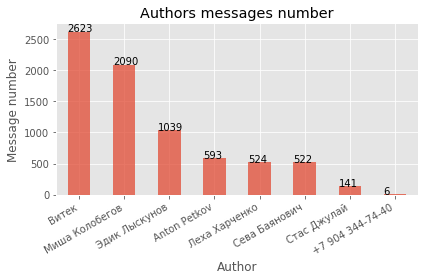

In [12]:
##### PLOTTING PART
### plots media/text percentage

### calculating and plotting overall authors messages number
authors_count = df.groupby(['author']).count()['text']
authors_count = authors_count.sort_values(ascending=False)
if authors_num > 10:
	title = 'Top 10 authors messages number'
	authors_count = authors_count.iloc[:10]
else:
	title = 'Authors messages number'
ax = authors_count.plot(kind='bar', title=title, alpha=0.75)
ax.set_ylabel('Message number')
ax.set_xlabel('Author')
for i in ax.patches:
	ax.text(i.get_x(), i.get_height(), str(int(i.get_height())))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') # rotating long xticks and make them confy to read
plt.tight_layout()
plt.show()

Chart (top-5 also) of text/media messages authors. You can see the preferences of each of them.   
Some like to write, some like to send nudes and kittens.   

media,Media,Text
author,,
Витек,630.0,1993.0
Миша Колобегов,503.0,1587.0
Эдик Лыскунов,169.0,870.0
Anton Petkov,93.0,500.0
Сева Баянович,133.0,389.0


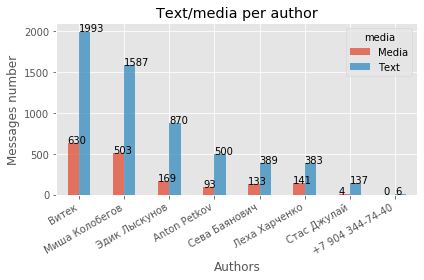

In [13]:
### calculating media/text ratio per author and plotting it
medias_per_capita = df.groupby(['author', 'media']).count()['text']
medias_per_capita = medias_per_capita.unstack(level=1)
medias_per_capita = medias_per_capita.sort_values(by='Text', ascending=False)
if authors_num > 10:
	medias_per_capita = medias_per_capita.iloc[:10, :]
	title = 'Top 10 media/text per author'
else:
	title = 'Text/media per author'

display(medias_per_capita.head())

ax = medias_per_capita.plot(kind='bar', title=title, alpha=0.75)
ax.set_ylabel('Messages number')
ax.set_xlabel('Authors')
for i in ax.patches:
	ax.text(i.get_x(), i.get_height(), str(int(i.get_height())))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right') # rotating long xticks and make them confy to read
plt.tight_layout()
plt.show()

Overall chat activity chart: you might notice the main holidays or debates.

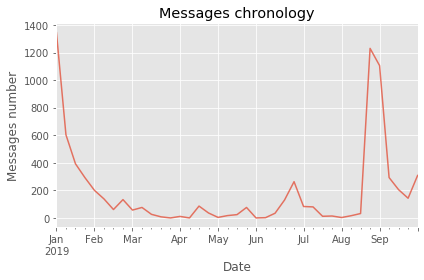

In [14]:
### plotting overall messages history
msg_weekly.plot(kind='line', title='Messages chronology', alpha=0.75)
plt.xlabel('Date')
plt.ylabel('Messages number')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Chart showing using medias vs. text:

media
Media    1673
Text     5865
Name: text, dtype: int64


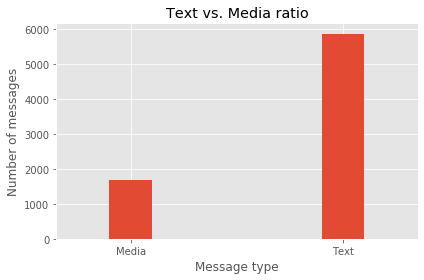

In [15]:
medias = df.groupby(['media']).count()['text']
print(medias)
medias.plot(kind='bar', title='Text vs. Media ratio', width=0.20)
plt.xlabel('Message type')
plt.ylabel('Number of messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Chart with average messages number in particular hous of the day:
It's better to ask your questions in top hours, the probability of recieving the answer fast will be higher.

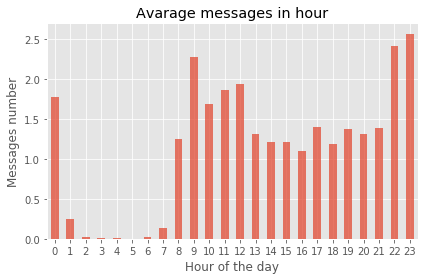

In [16]:
avg_msg_hour.plot(kind='bar', title='Avarage messages in hour', alpha=0.75, )
plt.xlabel('Hour of the day')
plt.ylabel('Messages number')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Top 20 words used in chat: (limited with not-less then 3 characters words.   
Top 20 swear words used in chat.   

|Word|Number of occurences|
|---|---|
|   |   |

In [17]:
print('Top 20 words used in chat:')
display(pd.DataFrame(words_dict.most_common(20)))
print('\n')
print('Top 20 swear words: \n')
display(pd.DataFrame(swears_dict[:20]))
print('\n')
print('Overall swears in chat percent:')
print(round((df['swears_num'].sum() / df['words_num'].sum()) * 100, 4))

Top 20 words used in chat:


,0,1
0,брат,207
1,че,148
2,бля,78
3,ебать,75
4,новая,70
5,пиздец,66
6,братан,65
7,блять,58
8,хз,50
9,помню,48




Top 20 swear words: 



,0,1
0,ебать,75
1,пиздец,66
2,нахуй,32
3,хуй,30
4,пизда,24
5,ахуеть,16
6,хуйня,13
7,ахуел,11
8,похуй,11
9,хуйню,7




Overall swears in chat percent:
1.8766


#### Trying to generate 20 messages using Markov chaing model trained with messages of the most active author in chat.

In [18]:
### procesing some markov chains generated messages
### trying to generate 20 messages
def shit_detector(string):
    if (string[0] == '<' and string[-1] == '>') or \
        'http' in string:
        return False
    else:
        return True
    
corpus = df[(df['author'] == most_active) & (df['text'].apply(shit_detector))]['text']

corpus = '\n'.join(corpus.tolist())

text_model = markovify.NewlineText(corpus, well_formed=False)

number_of_lines = 20
count = 0

print('Author: ', most_active, '\n')

while True:	### Skiping None values
	output = text_model.make_sentence()
	if output != None:
		print(output)
		if count == number_of_lines:
			break
		else:
			count += 1

Author:  Витек 

Я ща на работу в школу пойду
Ну там я думаю можно
С графиком работы на этой недели в любое время
Здарова братва! Ну че завтра по вечеру, часов 7 - 8? Стас, ты че не спишь в воскресенье так рано😅
Брат, у нас все в ваших руках
Мы от меня с 5 этажа спускались и на дневном. Ты все равно препарат же не бесплатно так давали в аптеках
А главное с КЕМ! А то потом вон пацаны на работе рассказывает, с залупы под названием контакт у него лопнула🤣
Сева будет руль крутить, а ты чем там в Рязани занимаешься?
Да она уже не играю
Аааа ебать это ты их делаеш ?😅
Брат, уже пряники с пальмовым маслом я в нем не шарю особо понимаю что пизда
Говорю ну че там?
Че прям сейчас скажут че там с Лехой тоже мутите
Братья, никто случайно не едет по вавилова на северный?
Повидались бы хоть в леруйе в электрике работаю😅
Севка так че как операция прошла?
Очков? А че приезжает?
Мишаня, брат, че там как?
Эдик, а ты чем там в день по 9 мультов на кассе
Ну в кровь нахуй
Давайте там с бони м?😅
